<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/4_Transfer_Learn_Sound_Classification_with_YAMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sound Classification using YAMNet - Fully Fixed Version


In [4]:
!pip install -q tensorflow tensorflow_hub librosa soundfile

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import pandas as pd
import os

In [6]:
# Load YAMNet model
print("Loading YAMNet model...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

Loading YAMNet model...


In [7]:
# Load class names
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])
print(f"Loaded {len(class_names)} class names")

Loaded 521 class names


In [8]:
# Function to load and preprocess audio
def load_audio_file(file_path):
    """Load audio file and convert to YAMNet format."""
    try:
        # Read the audio file
        audio, sample_rate = sf.read(file_path, dtype='float32')

        # Convert to mono if stereo
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)

        # Resample to 16kHz if necessary
        if sample_rate != 16000:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)

        return audio
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None

In [9]:
# Function to classify audio
def classify_audio(audio):
    """Classify audio using YAMNet."""
    if audio is None:
        return None, None, None

    # Get embeddings and predictions - YAMNet returns 3 values
    scores, embeddings, spectrogram = yamnet_model(audio)

    return scores.numpy(), embeddings.numpy(), spectrogram.numpy()

In [10]:
# Create and save a test audio file
!pip install -q pydub
from pydub.generators import Sine

In [11]:
# Generate a test tone
print("\nGenerating test audio...")
tone = Sine(440).to_audio_segment(duration=1000)  # 440 Hz for 1 second
tone.export("test_tone.wav", format="wav")


Generating test audio...


<_io.BufferedRandom name='test_tone.wav'>

In [12]:
# Generate synthetic environmental sound
sample_rate = 16000
duration = 3  # seconds
t = np.linspace(0, duration, sample_rate * duration)

In [13]:
# White noise for rain
rain = np.random.normal(0, 0.1, len(t))
# Add some low-frequency components
rain += 0.05 * np.sin(2 * np.pi * 100 * t)

In [14]:
# Save the synthetic rain sound
sf.write('synthetic_rain.wav', rain.astype(np.float32), sample_rate)

In [15]:
# Classify the test audio
print("\nClassifying test tone...")
test_audio = load_audio_file('test_tone.wav')


Classifying test tone...


Number of time windows: 2
Number of classes: 521

Top 5 predictions (averaged across time):
Telephone: 0.989
Busy signal: 0.981
Alarm: 0.911
Dial tone: 0.858
Sine wave: 0.076

Predictions for each time window:
Window 0: Telephone (0.995)
Window 1: Telephone (0.983)


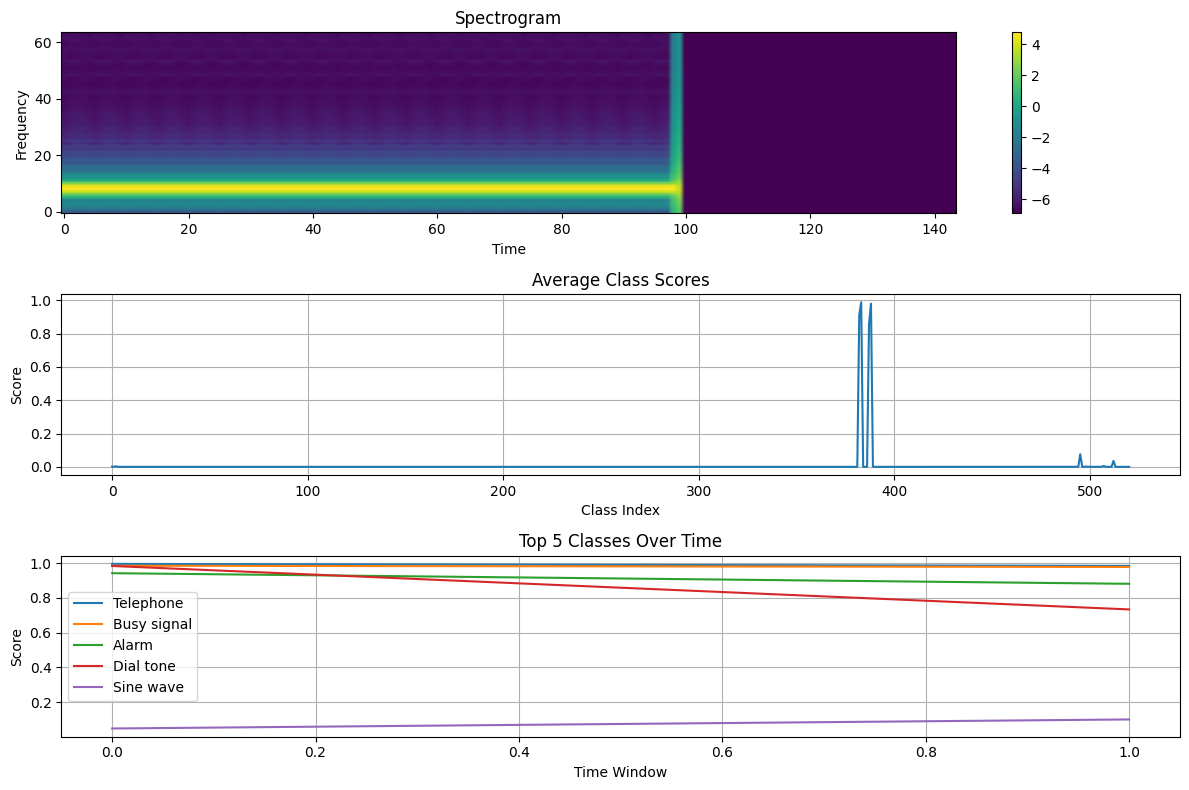

In [16]:
if test_audio is not None:
    scores, embeddings, spectrogram = classify_audio(test_audio)

    if scores is not None:
        # Display results
        print(f"Number of time windows: {scores.shape[0]}")
        print(f"Number of classes: {scores.shape[1]}")

        # Get average scores across all time windows
        avg_scores = np.mean(scores, axis=0)
        top_5_indices = np.argsort(avg_scores)[-5:][::-1]

        print("\nTop 5 predictions (averaged across time):")
        for idx in top_5_indices:
            print(f"{class_names[idx]}: {avg_scores[idx]:.3f}")

        # Show predictions for each time window
        print("\nPredictions for each time window:")
        for i in range(min(3, scores.shape[0])):  # Show first 3 windows
            top_class_idx = np.argmax(scores[i])
            print(f"Window {i}: {class_names[top_class_idx]} ({scores[i][top_class_idx]:.3f})")

        # Visualize spectrogram and scores
        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.imshow(spectrogram.T, aspect='auto', origin='lower')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.colorbar()

        plt.subplot(3, 1, 2)
        plt.plot(avg_scores)
        plt.title('Average Class Scores')
        plt.xlabel('Class Index')
        plt.ylabel('Score')
        plt.grid(True)

        plt.subplot(3, 1, 3)
        # Show scores for top 5 classes over time
        for idx in top_5_indices:
            plt.plot(scores[:, idx], label=class_names[idx])
        plt.title('Top 5 Classes Over Time')
        plt.xlabel('Time Window')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [17]:
# Classify the synthetic rain sound
print("\nClassifying synthetic rain...")
rain_audio = load_audio_file('synthetic_rain.wav')

if rain_audio is not None:
    scores, embeddings, spectrogram = classify_audio(rain_audio)

    if scores is not None:
        avg_scores = np.mean(scores, axis=0)
        top_5_indices = np.argsort(avg_scores)[-5:][::-1]

        print("\nTop 5 predictions for synthetic rain:")
        for idx in top_5_indices:
            print(f"{class_names[idx]}: {avg_scores[idx]:.3f}")


Classifying synthetic rain...

Top 5 predictions for synthetic rain:
Spray: 0.450
Liquid: 0.316
Waterfall: 0.313
White noise: 0.261
Water: 0.200


In [18]:
# Transfer learning with YAMNet embeddings
print("\n--- Transfer Learning with YAMNet ---")

def create_custom_sound_classifier(num_classes):
    """Create custom sound classifier using YAMNet embeddings."""
    input_embeddings = tf.keras.Input(shape=(1024,), name='embeddings')

    x = tf.keras.layers.Dense(512, activation='relu')(input_embeddings)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_embeddings, outputs=outputs)
    return model


--- Transfer Learning with YAMNet ---


In [19]:
# Create a model for 5 custom sound classes
custom_classes = ['speech', 'music', 'silence', 'noise', 'other']
custom_model = create_custom_sound_classifier(len(custom_classes))

# Compile the model
custom_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nCustom sound classifier created!")
custom_model.summary()


Custom sound classifier created!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embeddings (InputLayer)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,413 (2.51 MB)

 Trainable params: 657,413 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Function to extract embeddings - FIXED
def extract_embeddings_from_audio(audio):
    """Extract YAMNet embeddings from audio."""
    if audio is None:
        return None

    # YAMNet returns 3 values, not 4
    scores, embeddings, spectrogram = yamnet_model(audio)

    # Average embeddings over time
    avg_embedding = tf.reduce_mean(embeddings, axis=0)
    return avg_embedding.numpy()

In [21]:
# Create synthetic training data
print("\nCreating synthetic training data...")
num_samples = 50
X_train = []
y_train = []

for i in range(num_samples):
    # Create different types of synthetic audio
    duration = 2.0
    t = np.linspace(0, duration, int(16000 * duration))

    if i % 5 == 0:  # Speech-like (varying frequencies)
        audio = np.sin(2 * np.pi * (400 + 100 * np.sin(2 * np.pi * 2 * t)) * t)
        audio += np.random.normal(0, 0.01, audio.shape)  # Add slight noise
        label = 0  # speech
    elif i % 5 == 1:  # Music-like (harmonics)
        audio = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)
        audio += 0.3 * np.sin(2 * np.pi * 1320 * t)
        label = 1  # music
    elif i % 5 == 2:  # Silence
        audio = np.zeros_like(t) + np.random.normal(0, 0.001, t.shape)
        label = 2  # silence
    elif i % 5 == 3:  # Noise
        audio = np.random.normal(0, 0.3, t.shape)
        label = 3  # noise
    else:  # Other (chirp)
        audio = np.sin(2 * np.pi * (200 + 1000 * t) * t)
        label = 4  # other

    # Normalize audio
    audio = audio.astype(np.float32)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    # Extract embeddings
    embedding = extract_embeddings_from_audio(audio)
    if embedding is not None:
        X_train.append(embedding)
        y_train.append(label)

X_train = np.array(X_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(custom_classes))

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Creating synthetic training data...
Training data shape: (50, 1024)
Labels shape: (50, 5)



Training custom classifier...
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.2194 - loss: 1.6538 - val_accuracy: 0.8000 - val_loss: 0.7950
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8545 - loss: 0.7741 - val_accuracy: 0.6000 - val_loss: 0.4536
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8326 - loss: 0.4553 - val_accuracy: 0.7000 - val_loss: 0.3438
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8267 - loss: 0.3613 - val_accuracy: 0.7000 - val_loss: 0.3101
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7344 - loss: 0.3270 - val_accuracy: 0.7000 - val_loss: 0.3042
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7875 - loss: 0.3107 - val_accuracy: 0.7000 - val_loss: 0.3022
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9288 - loss: 0.2108 - val_accuracy: 0.7000 - val_loss: 0.2991
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7160 - loss: 0.3600 - val_acc

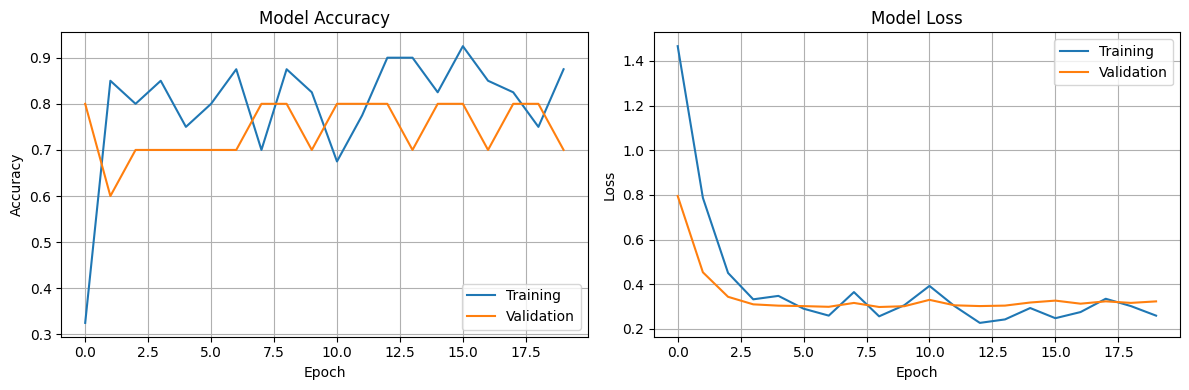

In [22]:
# Train the custom model
print("\nTraining custom classifier...")
history = custom_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Test the custom model
print("\nTesting custom classifier on various sounds...")

# Test on the tone
test_embedding = extract_embeddings_from_audio(test_audio)
if test_embedding is not None:
    test_embedding = np.expand_dims(test_embedding, 0)
    prediction = custom_model.predict(test_embedding, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    print(f"Test tone - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")


Testing custom classifier on various sounds...
Test tone - Predicted: music (confidence: 100.00%)


In [24]:
# Test on the rain sound
rain_embedding = extract_embeddings_from_audio(rain_audio)
if rain_embedding is not None:
    rain_embedding = np.expand_dims(rain_embedding, 0)
    prediction = custom_model.predict(rain_embedding, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    print(f"Synthetic rain - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")

Synthetic rain - Predicted: noise (confidence: 95.05%)


In [25]:
# Create a test for each class
print("\nTesting on synthetic examples of each class:")
test_duration = 1.0
test_t = np.linspace(0, test_duration, int(16000 * test_duration))

test_sounds = {
    'speech': np.sin(2 * np.pi * (400 + 100 * np.sin(2 * np.pi * 2 * test_t)) * test_t),
    'music': np.sin(2 * np.pi * 440 * test_t) + 0.5 * np.sin(2 * np.pi * 880 * test_t),
    'silence': np.zeros_like(test_t) + np.random.normal(0, 0.001, test_t.shape),
    'noise': np.random.normal(0, 0.3, test_t.shape),
    'other': np.sin(2 * np.pi * (200 + 1000 * test_t) * test_t)
}

for sound_type, audio in test_sounds.items():
    audio = audio.astype(np.float32)
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    embedding = extract_embeddings_from_audio(audio)
    if embedding is not None:
        embedding = np.expand_dims(embedding, 0)
        prediction = custom_model.predict(embedding, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]

        print(f"{sound_type} sound - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")


Testing on synthetic examples of each class:
speech sound - Predicted: speech (confidence: 95.95%)
music sound - Predicted: music (confidence: 100.00%)
silence sound - Predicted: noise (confidence: 84.19%)
noise sound - Predicted: noise (confidence: 76.88%)
other sound - Predicted: other (confidence: 95.71%)


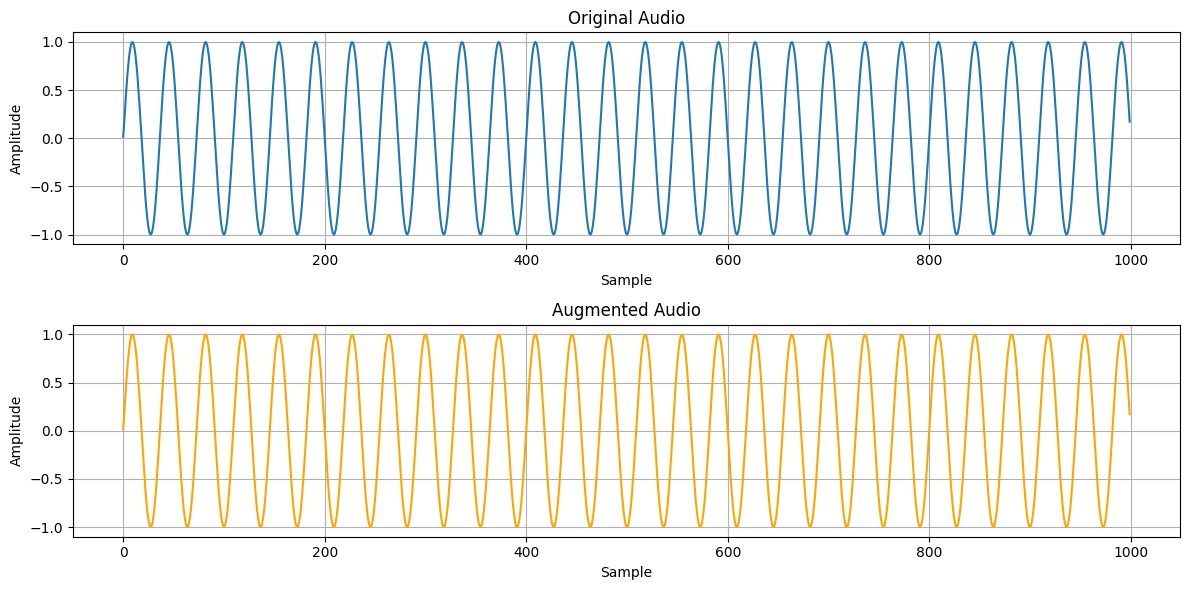


Augmented tone - Predicted: music (confidence: 100.00%)


In [26]:
# Data augmentation function
def augment_audio(audio, sample_rate=16000):
    """Apply data augmentation to audio."""
    augmented = audio.copy()

    # Time stretching (simplified version)
    if np.random.rand() > 0.5:
        stretch_factor = np.random.uniform(0.9, 1.1)
        augmented = librosa.effects.time_stretch(augmented, rate=stretch_factor)

    # Add noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise

    # Volume change
    if np.random.rand() > 0.5:
        volume_factor = np.random.uniform(0.7, 1.3)
        augmented *= volume_factor

    # Ensure proper length after augmentation
    if len(augmented) != len(audio):
        augmented = librosa.util.fix_length(augmented, size=len(audio))

    return augmented

# Demonstrate augmentation
if test_audio is not None:
    augmented_audio = augment_audio(test_audio)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(test_audio[:1000], label='Original')
    plt.title('Original Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(augmented_audio[:1000], label='Augmented', color='orange')
    plt.title('Augmented Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Test augmented audio
    aug_embedding = extract_embeddings_from_audio(augmented_audio)
    if aug_embedding is not None:
        aug_embedding = np.expand_dims(aug_embedding, 0)
        prediction = custom_model.predict(aug_embedding, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]

        print(f"\nAugmented tone - Predicted: {custom_classes[predicted_class]} (confidence: {confidence:.2%})")